# Forecasting Traffic Flow Using Deep Learning and Graph-Based Models

### Topic: Spatio-Temporal Prediction and Coordination of EV Charging Demand for Power System Resilience

## 1. Introduction

Urban traffic congestion remains a critical challenge for modern cities, affecting not only travel efficiency but also environmental sustainability and infrastructure planning. As transportation systems grow more complex, the need for accurate traffic forecasting becomes increasingly important to support intelligent routing, congestion mitigation, and data-driven urban mobility strategies.

This research focuses exclusively on **forecasting traffic flow** using real-world, high-resolution sensor data from **California’s Caltrans District 3**. The primary goal is to identify the most accurate and robust model for predicting traffic flow over short- and medium-term horizons. The selected model will later be integrated into a broader energy research pipeline for simulating and coordinating **electric vehicle (EV) charging demand**, but **EV modeling is not part of this notebook**.

To build reliable and scalable forecasting models, we adopt a comparative modeling strategy that spans baseline statistical methods, deep learning architectures, and graph-based neural networks. The underlying traffic data is first carefully cleaned, enriched with temporal features, and structured for spatio-temporal learning.



## 2. Project Objective

The objective of this notebook is to prepare the dataset and modeling pipeline necessary to:

- Forecast traffic flow at 12, 24, 48, and 72-hour horizons.
- Compare 9 distinct models.
- Select the best-performing model for downstream EV simulation integration.

This notebook focuses on **data cleaning**, **exploration**, and preparing features for model training. Model implementation and evaluation are handled in the follow-up notebook.


## 3. Modeling Strategy

We will evaluate nine models categorized as follows:

| Category                | Models                                                   |
|------------------------|-----------------------------------------------------------|
| **Baseline Models**     | Linear Regression, LSTM-only                              |
| **Literature Benchmark**| CNN-GRU-LSTM (reproduced from prior work)                 |
| **Graph-based Models**  | DCRNN-only, STGCN-only, GraphWaveNet-only                 |
| **Proposed Hybrids**    | DCRNN-GRU-LSTM, STGCN-GRU-LSTM, GraphWaveNet-GRU-LSTM     |

Each model is trained to forecast traffic flow over a **72-hour horizon**, allowing comparison across multiple time scales (12h, 24h, 48h, and 72h ahead).



## 4. Evaluation Metrics

Models are compared using the following metrics:

- **MAPE** (Mean Absolute Percentage Error)  
- **RMSE** (Root Mean Squared Error)  
- **MAE** (Mean Absolute Error)

These metrics are evaluated on the same test set for all models and across all forecast horizons.


## 5. Input Features Used Across All Models

All models use a consistent feature set, including:

- **Temporal Features**: hour, day, weekday, month, holiday  
- **Lag Features**: TotalFlow_lag_1 to lag_72  
- **Rolling Window Statistics**: mean, min, max, std (12h, 24h, 48h, 72h)  
- **Cyclical Features**: sine/cosine transforms of hour, day  
- **Graph Features** (for graph-based models):
  - *DCRNN*: CV-clustered adjacency matrix  
  - *STGCN*: Chebyshev graph Laplacian  
  - *GraphWaveNet*: Learns adjacency dynamically


## 6. Summary

This notebook documents the first stage of the traffic forecasting pipeline, covering:

- Merging and cleaning hourly traffic sensor data  
- Performing exploratory analysis to uncover temporal patterns and data quality issues  

The outcome is a clean, feature-rich dataset ready for feature engineering, model training and evaluation, which is conducted in the subsequent notebook.


## Importing Libraries

In [5]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dropout
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import warnings

In [6]:
warnings.filterwarnings('ignore')

## Merging and Loading Data

In [7]:
# Define folder path where the .txt files are located
folder_path = r"C:\Users\attafuro\Desktop\EV Charging Analysis"
output_file = os.path.join(folder_path, "merged_3months_traffic_data.csv")

# Get all .txt files in the folder
file_paths = glob.glob(os.path.join(folder_path, "*.txt"))

# Merge all .txt files into one CSV and delete the originals
with open(output_file, "w") as output:
    first_file = True

    for file in file_paths:
        print(f"Processing: {file}")
        
        # Read and write the .txt file in chunks (to handle large files efficiently)
        for chunk in pd.read_csv(file, delimiter=",", chunksize=10000):
            chunk.to_csv(output, index=False, header=first_file, mode="a")
            first_file = False

        # Delete the file after processing
        os.remove(file)
        print(f"Deleted: {file}")

print(f" Merge completed! CSV saved as '{output_file}'")


 Merge completed! CSV saved as 'C:\Users\attafuro\Desktop\EV Charging Analysis\merged_3months_traffic_data.csv'


# Data Cleaning and Exploratory Data Analysis

In [ ]:
# Define the correct column names
column_names = [
    "Timestamp", "Station", "District", "Route", "Direction of Travel", "Lane Type",
    "Station Length", "Samples", "% Observed", "Total Flow", "Avg Occupancy", "Avg Speed",
    "Delay (V_t=35)", "Delay (V_t=40)", "Delay (V_t=45)", "Delay (V_t=50)", "Delay (V_t=55)", "Delay (V_t=60)"
]

In [ ]:
# Identify extra columns (Lane N data) and rename accordingly
num_extra_cols = len(df.columns) - len(column_names)
for i in range(1, num_extra_cols // 3 + 1):  
    column_names.extend([
        f"Lane {i} Flow", f"Lane {i} Avg Occ", f"Lane {i} Avg Speed"
    ])

# Apply new column names
df.columns = column_names

# Save the cleaned dataset
cleaned_file_path = r"C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv"
df.to_csv(cleaned_file_path, index=False)

print(f" Column names fixed! Cleaned data saved as '{cleaned_file_path}'.")

In [9]:
df = pd.read_csv(r"C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv")

In [10]:
# Convert 'Timestamp' to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%m/%d/%Y %H:%M:%S")

In [11]:
df.head()

,Timestamp,Station,District,Route,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,...,Lane 5 Avg Speed,Lane 6 Flow,Lane 6 Avg Occ,Lane 6 Avg Speed,Lane 7 Flow,Lane 7 Avg Occ,Lane 7 Avg Speed,Lane 8 Flow,Lane 8 Avg Occ,Lane 8 Avg Speed
0,2024-10-01,308512,3,50,W,ML,3.995,197,0,497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-01,311831,3,5,S,OR,NaN,101,92,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-01,311832,3,5,S,FR,NaN,101,92,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-01,311844,3,5,N,OR,NaN,202,92,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-01,311847,3,5,N,OR,NaN,303,92,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [13]:
# Display initial summary
print(" Initial Data Overview:")
print(df.info())  # Check data types

 Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4114680 entries, 0 to 4114679
Data columns (total 9 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Timestamp            datetime64[ns]
 1   Station              int64         
 2   Route                int64         
 3   Direction of Travel  object        
 4   Total Flow           float64       
 5   Avg Speed            float64       
 6   % Observed           int64         
 7   Samples              int64         
 8   Lane Type            object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 282.5+ MB
None


In [14]:
print("\nMissing Values:\n", df.isnull().sum())  # Count missing values


Missing Values:
 Timestamp                    0
Station                      0
Route                        0
Direction of Travel          0
Total Flow              303776
Avg Speed              1582594
% Observed                   0
Samples                      0
Lane Type                    0
dtype: int64


In [15]:
df = df.loc[:, df.columns != "Avg Speed"]

In [16]:
# Fill Total Flow missing values with median of same Route & Lane Type
df['Total Flow'] = df.groupby(['Route', 'Lane Type'])['Total Flow'].transform(lambda x: x.fillna(x.median()))

In [17]:
df["Total Flow"] = df["Total Flow"].fillna(df["Total Flow"].median())

In [18]:
print(" Missing Values After Cleaning:\n", df.isnull().sum())

 Missing Values After Cleaning:
 Timestamp              0
Station                0
Route                  0
Direction of Travel    0
Total Flow             0
% Observed             0
Samples                0
Lane Type              0
dtype: int64


In [19]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,2024-10-01,308512,50,W,497.0,0,197,ML
1,2024-10-01,311831,5,S,27.0,92,101,OR
2,2024-10-01,311832,5,S,78.0,92,101,FR
3,2024-10-01,311844,5,N,43.0,92,202,OR
4,2024-10-01,311847,5,N,73.0,92,303,OR


In [20]:
df.describe()

,Timestamp,Station,Route,Total Flow,% Observed,Samples
count,4114680,4.114680e+06,4.114680e+06,4.114680e+06,4.114680e+06,4.114680e+06
mean,2024-11-15 21:55:32.850476800,1.555704e+06,6.332029e+01,9.391891e+02,7.892594e+01,1.841558e+02
min,2024-10-01 00:00:00,3.085110e+05,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2024-10-23 20:00:00,3.160180e+05,5.000000e+01,8.800000e+01,9.200000e+01,1.010000e+02
50%,2024-11-15 21:00:00,3.193550e+05,6.500000e+01,4.000000e+02,1.000000e+02,1.200000e+02
75%,2024-12-08 22:00:00,3.048042e+06,8.000000e+01,1.205000e+03,1.000000e+02,2.400000e+02
max,2024-12-31 23:00:00,3.900024e+06,5.050000e+02,9.913000e+03,1.000000e+02,9.600000e+02
std,NaN,1.401927e+06,3.830528e+01,1.290288e+03,3.837036e+01,1.285258e+02


In [21]:
# Extract time components
df["Hour"] = df["Timestamp"].dt.hour
df["Day"] = df["Timestamp"].dt.date
df["Week"] = df["Timestamp"].dt.to_period("W").apply(lambda r: r.start_time)

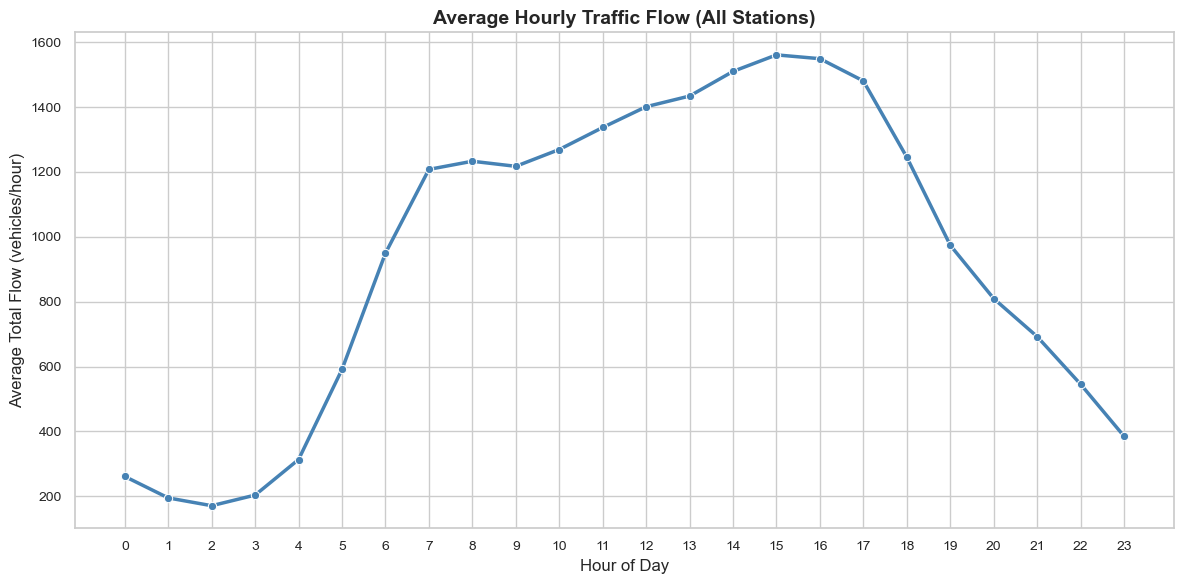

In [22]:
# Group and compute average total flow by hour
hourly_avg = df.groupby("Hour")["Total Flow"].mean().reset_index()

# Set plot style for a cleaner academic look
sns.set(style="whitegrid", context="notebook")

# Create the figure
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_avg, x="Hour", y="Total Flow", marker="o", linewidth=2.5, color="steelblue")

# Title and labels
plt.title("Average Hourly Traffic Flow (All Stations)", fontsize=14, fontweight='bold')
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Average Total Flow (vehicles/hour)", fontsize=12)
plt.xticks(range(0, 24), fontsize=10)
plt.yticks(fontsize=10)

# Tight layout and save high-res version
plt.tight_layout()
plt.savefig("avg_hourly_traffic_flow.png", dpi=300, bbox_inches="tight")

plt.show()


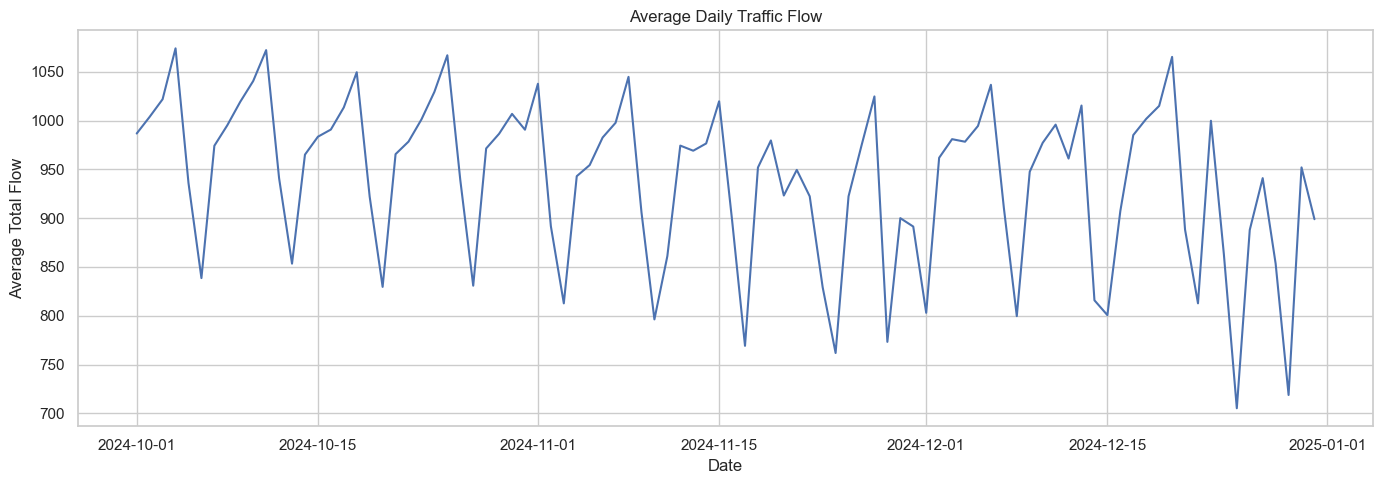

In [23]:
daily_avg = df.groupby("Day")["Total Flow"].mean().reset_index()

plt.figure(figsize=(14, 5))
sns.lineplot(data=daily_avg, x="Day", y="Total Flow")
plt.title("Average Daily Traffic Flow")
plt.xlabel("Date")
plt.ylabel("Average Total Flow")
plt.tight_layout()
plt.show()

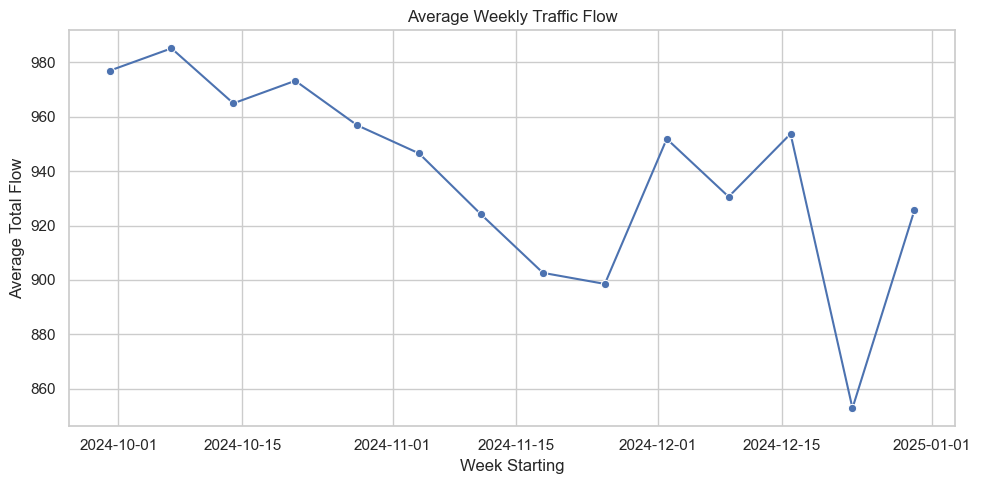

In [24]:
weekly_avg = df.groupby("Week")["Total Flow"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=weekly_avg, x="Week", y="Total Flow", marker="o")
plt.title("Average Weekly Traffic Flow")
plt.xlabel("Week Starting")
plt.ylabel("Average Total Flow")
plt.tight_layout()
plt.show()

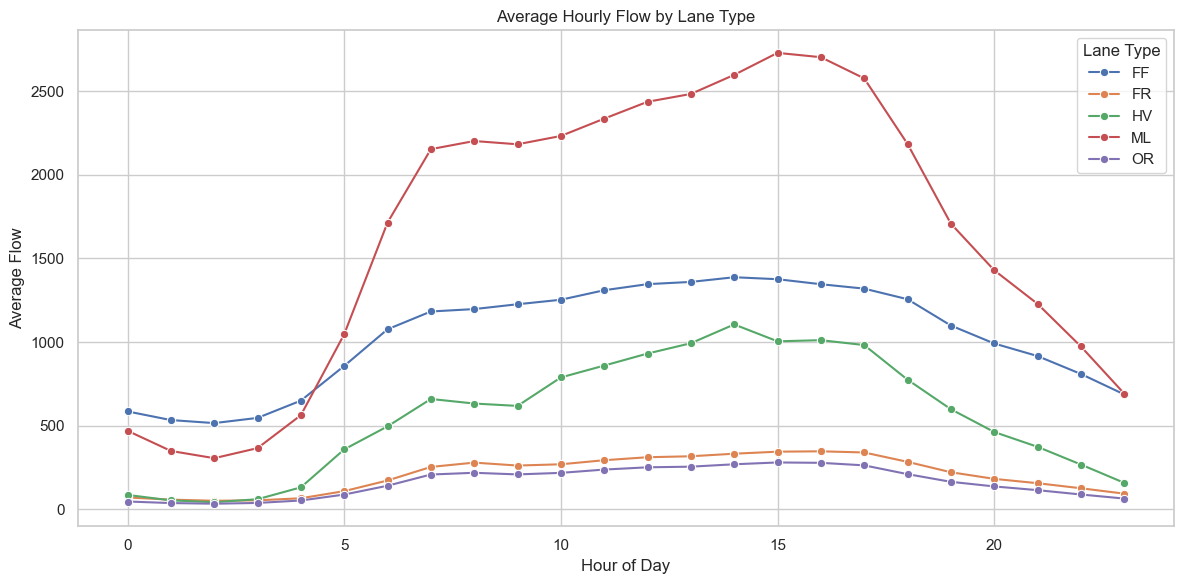

In [25]:
hourly_lane = df.groupby(["Hour", "Lane Type"])["Total Flow"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_lane, x="Hour", y="Total Flow", hue="Lane Type", marker="o")
plt.title("Average Hourly Flow by Lane Type")
plt.xlabel("Hour of Day")
plt.ylabel("Average Flow")
plt.legend(title="Lane Type")
plt.tight_layout()
plt.show()

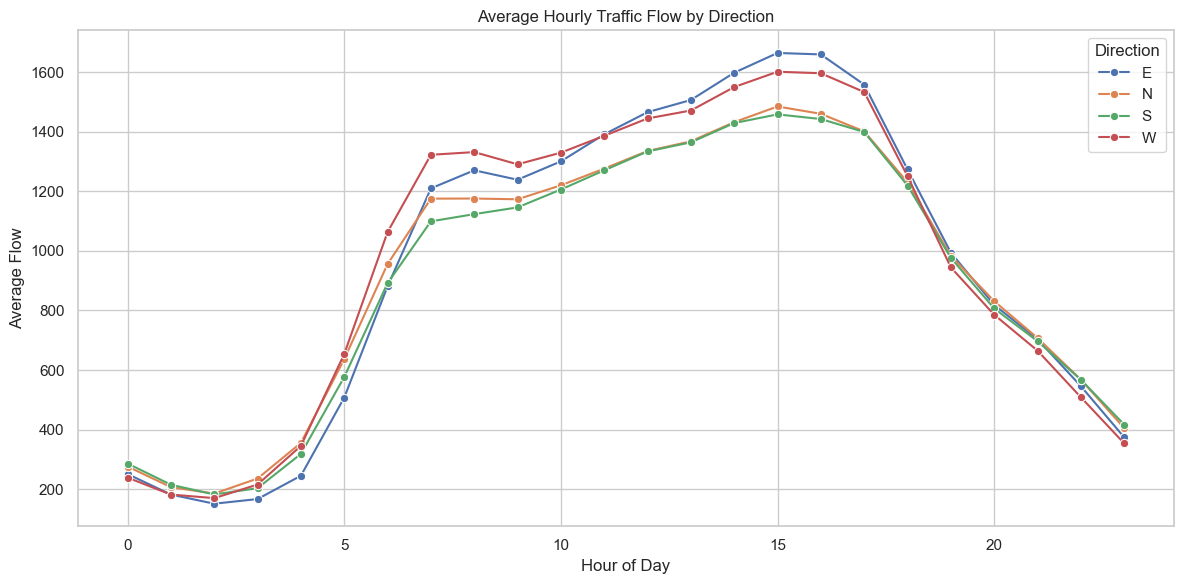

In [26]:
hourly_dir = df.groupby(["Hour", "Direction of Travel"])["Total Flow"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_dir, x="Hour", y="Total Flow", hue="Direction of Travel", marker="o")
plt.title("Average Hourly Traffic Flow by Direction")
plt.xlabel("Hour of Day")
plt.ylabel("Average Flow")
plt.legend(title="Direction")
plt.tight_layout()
plt.show()

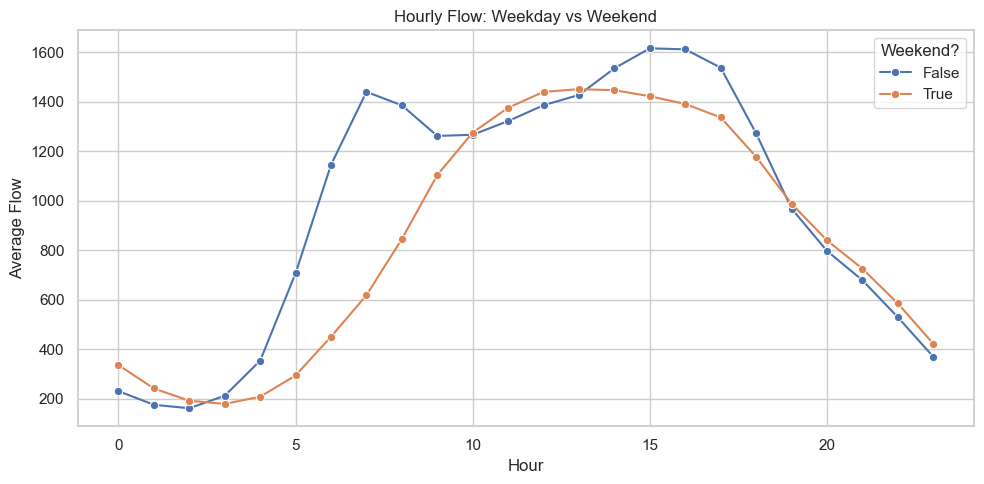

In [27]:
df["DayOfWeek"] = df["Timestamp"].dt.day_name()
df["IsWeekend"] = df["DayOfWeek"].isin(["Saturday", "Sunday"])

hourly_weekend = df.groupby(["Hour", "IsWeekend"])["Total Flow"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_weekend, x="Hour", y="Total Flow", hue="IsWeekend", marker="o")
plt.title("Hourly Flow: Weekday vs Weekend")
plt.xlabel("Hour")
plt.ylabel("Average Flow")
plt.legend(title="Weekend?")
plt.tight_layout()
plt.show()